In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from numpy.linalg import svd
import scipy.linalg as la
from scipy.linalg import sqrtm
import scipy.linalg as la
from numpy.linalg import matrix_power
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
I=np.eye(2,dtype="complex")
H=np.array([[1,1],[1,-1]])/np.sqrt(2)
n_qubits=5
np.random.seed(0)

# 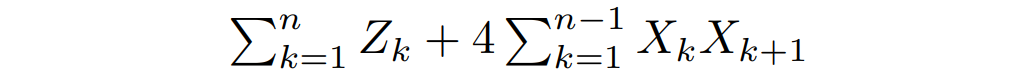

In [2]:
def is_unitary(matrix):
    if(np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))<0.00001):
        return True
    return np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))
def get_psi(n_qubits):
    psi = np.reshape(np.array([np.random.normal() for i in range(2**n_qubits)]) + 1j*np.array([np.random.normal() for i in range(2**n_qubits)]), (2**n_qubits,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    return psi
psi0=get_psi(n_qubits-1)
psi0=np.kron(get_psi(1),psi0)
def purity(psi0): #calculating purity of the first qubit
    psi = np.reshape(psi0, tuple([2] + [2 ** (n_qubits - 1)] + [1]))
    psi_conjugate = np.reshape(psi0, tuple([1] + [2] + [2 ** (n_qubits - 1)])).conjugate()
    rho = np.tensordot(psi, psi_conjugate, axes=([2], [0]))
    rho_first_qubit = np.trace(rho, axis1=1, axis2=3)
    return np.trace(rho_first_qubit @ rho_first_qubit).real
def z_global(n,n_qubits=n_qubits):
    if n==0:
        gate=Z
    else:
        gate=I
    for i in range(1,n_qubits):
        if i==n:
            gate=np.kron(gate,Z)
        else:
            gate=np.kron(gate,I)
    return gate
def xx_global(n,n_qubits=n_qubits):
    if n==0:
        gate=X
    else:
        gate=I
    for i in range(1,n_qubits):
        if (i==n or i==n+1):
            gate=np.kron(gate,X)
        else:
            gate=np.kron(gate,I) 
    return gate
def Fidelity(a,b):
    return np.real(np.trace(sqrtm(sqrtm(b@b.T.conjugate())@(a@a.T.conjugate())@sqrtm(b@b.T.conjugate())))**2)
def evolution(t,Hamiltonian,psi0=psi0):
    return la.expm(-1j*Hamiltonian*t)@psi0
def Trotter(t,steps,n_qubits=n_qubits):
    dt=t/steps
    gate=np.eye(2**n_qubits,dtype=complex)
    step=la.expm(-1j*dt*np.array([z_global(k) for k in range(n_qubits)]).sum(axis=0))
    for k in range(n_qubits-1):
        step=la.expm(-4j*dt*xx_global(k))@step
    for i in range(steps):
        gate=step@gate
    return gate       

In [3]:
#Hamiltonian definition
Hamiltonian=np.array([z_global(k) for k in range(n_qubits)]+[4*xx_global(k) for k in range(n_qubits-1)]).sum(axis=0)

In [4]:
#initialization empty arrays (i will fill it in the next section)
N2=2
N10=10
N100=100
purity_samples2=np.array([1])
purity_samples10=np.array([1])
purity_samples100=np.array([1])
purity_ideal=np.array([
    np.real(
        purity(
            evolution(i,Hamiltonian=Hamiltonian)))for i in np.linspace(0,1,100)])
errors2=np.array([0])
errors10=np.array([0])
errors100=np.array([0])

In [5]:
#evolution
grid=100
for i in range(1,grid):
    psi=Trotter(i/grid,N2)@psi0
    purity_samples2=np.append(purity_samples2,np.real(purity(psi)))
    errors2=np.append(errors2,1-Fidelity(psi,evolution(i/grid,Hamiltonian=Hamiltonian)))
for i in range(1,grid):
    psi=Trotter(i/grid,N10)@psi0
    purity_samples10=np.append(purity_samples10,np.real(purity(psi)))
    errors10=np.append(errors10,1-Fidelity(psi,evolution(i/grid,Hamiltonian=Hamiltonian)))
for i in range(1,grid):
    psi=Trotter(i/grid,N100)@psi0
    purity_samples100=np.append(purity_samples100,np.real(purity(psi)))
    errors100=np.append(errors100,1-Fidelity(psi,evolution(i/grid,Hamiltonian=Hamiltonian)))

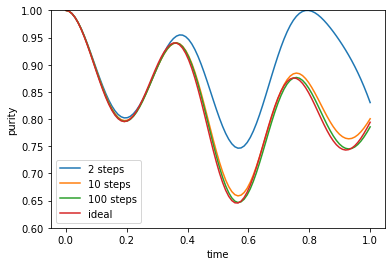

In [6]:
#final purity values
plt.plot(np.linspace(0,1,grid),purity_samples2,label="2 steps")
plt.plot(np.linspace(0,1,grid),purity_samples10,label="10 steps")
plt.plot(np.linspace(0,1,grid),purity_samples100,label="100 steps")
plt.plot(np.linspace(0,1,grid),purity_ideal,label="ideal")
plt.ylim([0.6, 1])
plt.xlabel("time")
plt.ylabel("purity")
plt.legend()
plt.show()

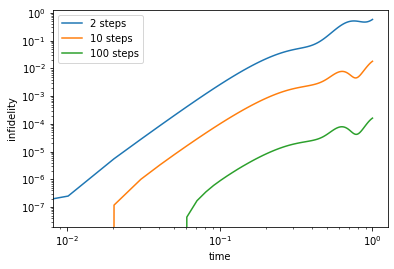

In [7]:
#final errors values
plt.plot(np.linspace(0,1,grid),errors2,label="2 steps")
plt.plot(np.linspace(0,1,grid),errors10,label="10 steps")
plt.plot(np.linspace(0,1,grid),errors100,label="100 steps")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("time")
plt.ylabel("infidelity")
plt.legend()
plt.show()

# spin echo

# 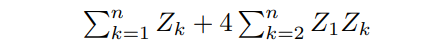

In [8]:
n_qubits=6
psi0=get_psi(n_qubits-1)
psi0=np.kron(get_psi(1),psi0)
def z1zk(k,n_qubits=n_qubits):
    gate=Z
    for i in range(1,n_qubits):
        if k==i:
            gate=np.kron(gate,Z)
        else:
            gate=np.kron(gate,I)
    return gate
def x_global(k,n_qubits=n_qubits):
    if k==0:
        gate=X
    else:
        gate=I
    for i in range(1,n_qubits):
        if k==i:
            gate=np.kron(gate,X)
        else:
            gate=np.kron(gate,I)
    return gate
def get_non_diag(psi): #non-diagonal element of the denisty matrix of the first qubit 
    N = psi.shape[0]//2
    Psi = np.reshape(psi, (2, N))
    rho_ = Psi@np.conjugate(Psi.T)
    return rho_[0, 1]

In [9]:
#Hamiltonian initialization
Hamiltonian=np.array([
    z_global(k,n_qubits=n_qubits) for k in range(n_qubits)]+
    [4*z1zk(k) for k in range(1,n_qubits)]).sum(axis=0)

In [10]:
non_diag_samples=np.array([np.abs(
    get_non_diag(
        evolution(i,Hamiltonian=Hamiltonian,psi0=psi0))) for i in np.linspace(0,1,1000)])

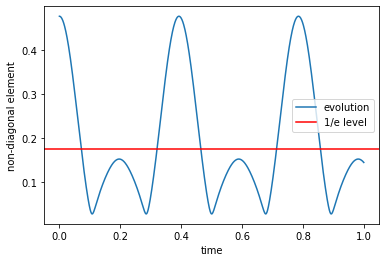

In [11]:
plt.plot(np.linspace(0,1,1000),non_diag_samples,label="evolution")
plt.axhline(y=np.abs(get_non_diag(psi0))/np.e, color='r', linestyle='-',label="1/e level")
plt.legend()
plt.xlabel("time")
plt.ylabel("non-diagonal element")
plt.show()

In [12]:
level=np.array([
    np.abs(get_non_diag(psi0)/get_non_diag(evolution(i,Hamiltonian=Hamiltonian,psi0=psi0)))
    for i in np.linspace(0.071825,0.07183,10)])

In [13]:
level #comparing  with e=2.718281828459045

array([2.71829404, 2.7183439 , 2.71839375, 2.71844361, 2.71849347,
       2.71854334, 2.7185932 , 2.71864307, 2.71869293, 2.7187428 ])

In [14]:
T2=0.071825

In [15]:
# evolution process with and without spin echo
self_evolution=np.array([np.real(purity(evolution(i,Hamiltonian=Hamiltonian,psi0=psi0))) for i in np.linspace(0,2*T2,101)])
echo=np.array([self_evolution[i] for i in range(50)]+[np.real(
    purity(
        evolution(
            i,Hamiltonian=Hamiltonian,psi0=x_global(0)@evolution(T2,Hamiltonian=Hamiltonian,psi0=psi0)))) for i in np.linspace(0,2*T2,101)[:51:]])

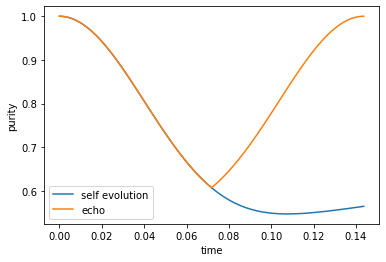

In [16]:
plt.plot(np.linspace(0,2*T2,101),self_evolution,label="self evolution")
plt.plot(np.linspace(0,2*T2,101),echo,label="echo")
plt.legend()
plt.xlabel("time")
plt.ylabel("purity")
plt.show()